## PDE with a jump at a interface

In this Notebook we want to solve a simple Poisson Problem with a Robin-Condition at a interface. 

We take $\Omega \subset \mathbb{R}^2$ as the rectangle $(0, 1) \times (0, 1)$
and denote with $\Gamma$ the interface defined as a line from $(0.5, 0)$ to $(0.5, 1)$.
\
We want to solve the following problem:
\begin{align*}
    \Delta u_i &= 0, \text{ in } \Omega \\
    u_1(0, y) &= 0 , \text{ for } y \in [0, 1] \\
    u_2(1, y) &= 2 , \text{ for } y \in [0, 1] \\
    \vec{n} \nabla u_i(x, y) &= 0 , \text{ for } x \in [0, 1], y \in \{0, 1\}\\
    \vec{n} \nabla u_i &= u_2 - u_1, \text{ for } x \in \Gamma
\end{align*}
for $i = 1, 2$ and with the wanted solution $u=(u_1, u_2)$, split up into left and right part.

One can see that the analytic solution is $u_1(x, y) = x$ and $u_2(x, y) = 1 + x$.

In [1]:
import torchphysics as tp
import torch

# set GPU:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

First step: define the spaces. Here we also use two different output spaces, since we will create different neural networks for the left and right solution.

In [2]:
X = tp.spaces.R2('x')
U_l = tp.spaces.R1('u_l') # output left
U_r = tp.spaces.R1('u_r') # output right

Next are the neural networks. Here we use two different ones, since we know that we have a discontinuity and expect that one network can not approximate the jump.

Two evaluate both models in a condition, we use the class tp.models.Parallel. This class get an arbitrary number of models as an input and evaluates them, so one can use all of them in a condition.

Since we know that our solution is pretty simple, we use small neural networks.

In [3]:
model_l = tp.models.FCN(input_space=X, output_space=U_l, hidden=(10,10))
model_r = tp.models.FCN(input_space=X, output_space=U_r, hidden=(10,10))

parallel_model = tp.models.Parallel(model_l, model_r)

Next up is the domain. Here we have to decide how we want to translate the geometry and the whole problem into the code. There are essentially two different ways:

- Construct one larger rectangle and filter out the points in each condition to only apply each neural network at the correct position. This would mean we pass everywhere the *parallel_model* as an input and evaluate both models at every point. This may be in general somewhat faster in training, but the conditions will get harder to understand. Also the interface has to be defined with a *helper domain*.
- The other ides is to split up the domain from the beginning and define each condition for each domain. To only get the correct points, we can use the filter function already in the sampler. So the conditions will be easier to understand, but we get more conditions. For the interface, we can just use one side of the created rectangles and pass *parallel_model* as an input.

Here we will use the second way:

In [4]:
R_l = tp.domains.Parallelogram(X, origin=[0., 0.], corner_1=[0.5, 0], corner_2=[0, 1.0]) # left domain 
R_r = tp.domains.Parallelogram(X, origin=[0.5, 0], corner_1=[1, 0], corner_2=[0.5, 1.0]) # right domain

We start with the Dirichlet condition. We use a filter function to only get the points at the correct part of the boundary

In [5]:
def filter_left(x):
    return torch.isclose(x[:, :1], torch.tensor(0.0))

left_sampler = tp.samplers.RandomUniformSampler(domain=R_l.boundary, density=50,
                                                filter_fn=filter_left)

def dirich_residual_left(u_l):
    return u_l 

left_dirich_cond = tp.conditions.PINNCondition(module=model_l, sampler=left_sampler, 
                                               residual_fn=dirich_residual_left)

In [6]:
def filter_right(x):
    return torch.isclose(x[:, :1], torch.tensor(1.0))

right_sampler = tp.samplers.RandomUniformSampler(domain=R_r.boundary, density=50,
                                                 filter_fn=filter_right)

def dirich_residual_right(u_r):
    return u_r - 2.0

right_dirich_cond = tp.conditions.PINNCondition(module=model_r, sampler=right_sampler, 
                                                    residual_fn=dirich_residual_right)

Next up are Neumann condition at the top and bottom. The idea is the same as before. In the residual function we have to compute the normal vectors at each points, to get the normal derivative

In [7]:
def filter_top_bottom(x):
    return torch.logical_or(torch.isclose(x[:, 1:], torch.tensor(0.0)),
                            torch.isclose(x[:, 1:], torch.tensor(1.0)))

left_neumann_sampler = tp.samplers.RandomUniformSampler(domain=R_l.boundary, density=50,
                                                        filter_fn=filter_top_bottom)

def neumann_residual_left(u_l, x):
    normals = R_l.boundary.normal(x)
    return tp.utils.normal_derivative(u_l, normals, x)

left_neumann_cond = tp.conditions.PINNCondition(module=model_l, sampler=left_neumann_sampler, 
                                                    residual_fn=neumann_residual_left)

In [8]:
right_neumann_sampler = tp.samplers.RandomUniformSampler(domain=R_r.boundary, density=50,
                                                         filter_fn=filter_top_bottom)

def neumann_residual_right(u_r, x):
    normals = R_r.boundary.normal(x)
    return tp.utils.normal_derivative(u_r, normals, x)

right_neumann_cond = tp.conditions.PINNCondition(module=model_r, sampler=right_neumann_sampler, 
                                                     residual_fn=neumann_residual_right)

Now the PDE itself, here we dont need a filter:

In [9]:
left_pde_sampler = tp.samplers.RandomUniformSampler(domain=R_l, n_points=250)

def pde_residual_left(u_l, x):
    return tp.utils.laplacian(u_l, x)

left_pde_cond = tp.conditions.PINNCondition(module=model_l, sampler=left_pde_sampler, 
                                                residual_fn=pde_residual_left)

right_pde_sampler = tp.samplers.RandomUniformSampler(domain=R_r, n_points=250)

def pde_residual_right(u_r, x):
    return tp.utils.laplacian(u_r, x)

right_pde_cond = tp.conditions.PINNCondition(module=model_r, sampler=right_pde_sampler, 
                                                 residual_fn=pde_residual_right)

At last, the interface. Here we sample points on the right side of the left rectangle. And then pass both models as an input for the residual condition, e.g. use the defined *parallel_model*. 

Remark: this is the only time we use the *parallel_model*, everywhere else we could only pass either the left or right model

In [10]:
def filter_interface(x):
    return torch.isclose(x[:, :1], torch.tensor(0.5))

interface_sampler = tp.samplers.RandomUniformSampler(domain=R_l.boundary, density=50,
                                                     filter_fn=filter_interface)

def interface_residual(u_l, u_r, x):
    normals = R_l.boundary.normal(x)
    normal_left = tp.utils.normal_derivative(u_l, normals, x)
    normal_right = tp.utils.normal_derivative(u_r, -normals, x)
    error_left = normal_left - (u_r - u_l)
    error_right = normal_right - (u_l - u_r)
    return torch.cat((error_left, error_right))

interface_cond = tp.conditions.PINNCondition(module=parallel_model, # here pass in both models
                                                 sampler=interface_sampler, 
                                                 residual_fn=interface_residual)

Now we can also check if all points are distributed correctly:

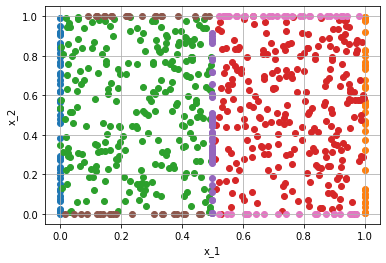

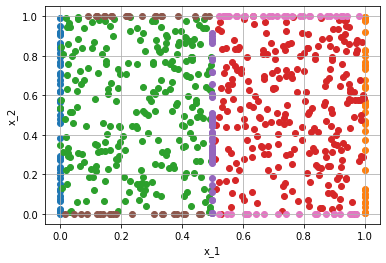

In [11]:
tp.utils.scatter(X, left_sampler, right_sampler, left_pde_sampler, right_pde_sampler, 
                 interface_sampler, left_neumann_sampler, right_neumann_sampler)

And finally start the training, where have to be carefull to not miss any condition:

In [15]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([left_dirich_cond, right_dirich_cond, left_pde_cond, 
                           right_pde_cond, interface_cond, left_neumann_cond, 
                           right_neumann_cond], optimizer_setting=optim)

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1,
                     max_steps=2000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 302   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
302       Trainable params
0         Non-trainable params
302       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 1999it [00:00, ?it/s]

The trainings loop is somewhat short and with a lr_scheduler a better minimum could be found, but for now that is enough.

Plot the solution like always. Where the representation is not perefected, since the plot itselfs assumes that the function is continuous.

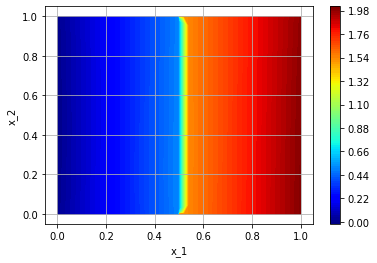

In [13]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=R_l + R_r, density=500, device='cuda')

def plot_fn(u_l, u_r, x):
    out = torch.zeros_like(u_l)
    smaller_half = (x[:, 0] <= 0.5)
    out[smaller_half] = u_l[smaller_half]
    larger_half = (x[:, 0] > 0.5)
    out[larger_half] = u_r[larger_half]
    return out

fig = tp.utils.plot(parallel_model, plot_function=plot_fn, 
                    point_sampler=plot_sampler, plot_type='contour_surface')

Since we know the exact the solution, we can plot the absolute error:

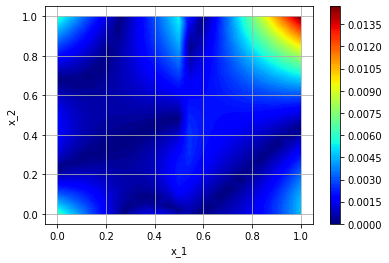

In [14]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=R_l + R_r, density=500, device='cuda')

def plot_fn(u_l, u_r, x):
    out = torch.zeros_like(u_l)
    smaller_half = (x[:, 0] <= 0.5)
    out[smaller_half] = u_l[smaller_half] - x[smaller_half, :1]
    larger_half = (x[:, 0] > 0.5)
    out[larger_half] = u_r[larger_half] - (1.0 + x[larger_half, :1])
    return torch.abs(out)

fig = tp.utils.plot(parallel_model, plot_function=plot_fn, 
                    point_sampler=plot_sampler, plot_type='contour_surface')